### **Backtesting**

This tutorial demonstrates how to backtest an optimized portfolio.

### **Introduction**

This tutorial guides you through the process of evaluating a portfolio's performance using backtesting techniques. We will analyze historical stock data, compute returns, and assess performance using different backtesting methods. The goal is to understand how a given portfolio would have performed under past market conditions and compare it with benchmarks.

By the end of this tutorial, you will be able to:
- Define and apply a **backtesting methodology**.
- Evaluate portfolio performance against **benchmarks**.
- Visualize the **backtest results**.


#### **Importing Required Libraries**

Before diving into portfolio optimization, we need to import the necessary libraries for optimization, data handling, visualization, and backtesting.

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Import modules from cuFOLIO
from cufolio import backtest, cvar_optimizer, cvar_utils, utils
from cuopt import linear_programming
from cuopt.linear_programming.solver_settings import PDLPSolverMode
from cuopt.linear_programming.solver.solver_parameters import *

#### **1. Problem Setup** 

In [2]:
# Define CVaR optimization parameters
cvar_params = cvar_optimizer.CVaR_Parameters(
    w_min=-0.3,          # Minimum asset weight allocation
    w_max=0.8,           # Maximum asset weight allocation
    c_min=0.1,           # Minimum cash holdings
    c_max=0.4,           # Maximum cash holdings
    L_tar=1.6,           # Leverage constraint (total long/short weight change)
    T_tar=None,          # Turnover constraint (limits portfolio deviation from an existing allocation)
    cvar_limit=0.1,      # Maximum allowed Conditional Value-at-Risk (CVaR)
    risk_aversion=0.5,   # Change to risk aversion levels (0 = maximize return subject to risk constraints)
    confidence=0.95,     # Confidence level for CVaR calculation
    num_scen=10000,      # Number of return scenarios to simulate
    fit_type="kde",      # Return distribution estimation method ('kde' for kernel density estimation, 'no_fit' for historical returns)
)

# Select dataset and regime information
dataset_name = "sp500"
dataset_directory = f"../data/stock_data/{dataset_name}.csv"

# Define return type and regime period
"""
# If you want to analyze different market conditions, you can use the following predefined periods:
scenarios = {
    'pre_crisis': ('2005-01-01', '2007-10-01'),
    'crisis': ('2007-10-01', '2009-04-01'),
    'post_crisis': ('2009-06-30', '2014-06-30'),
    'oil_price_crash': ('2014-06-01', '2016-03-01'),
    'FAANG_surge': ('2015-01-01', '2021-01-01'),
    'covid': ('2020-01-01', '2023-01-01'),
    'recent': ('2022-01-01', '2024-07-01')
}
"""
return_type = "LOG"
in_sample_start_date = "2022-01-04"
in_sample_end_date = "2024-01-01"
regime_dict = {"name": "recent", "range": (in_sample_start_date, in_sample_end_date)}

# Compute returns dictionary (set device for KDE computation)
returns_dict = cvar_utils.calculate_returns(
    dataset_directory, regime_dict, return_type, cvar_params, device="GPU"
)

# Instantiate CVaR optimization problem
example_cvar_problem = cvar_optimizer.CVaR(
    returns_dict=returns_dict, cvar_params=cvar_params
)

#### **2. Solve the Optimization Problem on GPU**

In [3]:
# Initialize solver settings
gpu_settings = linear_programming.SolverSettings()
gpu_settings.set_parameter(CUOPT_PDLP_SOLVER_MODE, PDLPSolverMode.Stable1)
gpu_settings.set_optimality_tolerance(1e-4)                                # Define optimality tolerance (default: 1e-4)
gpu_settings.set_parameter(CUOPT_INFEASIBILITY_DETECTION, False)           # Disable infeasibility detection
gpu_settings.set_parameter(CUOPT_ITERATION_LIMIT, 10000)                   # Set iteration limit to control convergence
gpu_settings.set_parameter(CUOPT_TIME_LIMIT, 10)                           # Set time limit for the solver to 10 seconds
gpu_settings.set_parameter(CUOPT_LOG_TO_CONSOLE, False)                    # Disable log to console

# Solve the optimization problem using the configured GPU solver settings
gpu_result, gpu_portfolio = example_cvar_problem.solve_optimization_problem(
    device="GPU", gpu_settings=gpu_settings
)

*************************
--- GPU CVaR Results---
recent: ('2022-01-04', '2024-01-01')
Scenarios: 10000
solver time: 0.0007 seconds
IO time: 0.8728 seconds
--- Optimal Portfolio ---
Long--CAH: 0.114
Short--EL: -0.074
Long--FICO: 0.5
Short--ILMN: -0.123
Long--JBL: 0.09
Long--LLY: 0.391
Short--MTCH: -0.3
cash: 0.4
*************************



#### **3. Run Backtest**

This section evaluates the performance of a given portfolio over a specified time period using different backtesting methods.

**Parameters:**
- **`test_portfolio`**: A `Portfolio` class object representing the portfolio to be tested.
- **`test_returns_dict`**: A dictionary containing returns data for the specified test period.
- **`risk_free`**: The risk-free rate used for cash.
- **`test_method`**: The method used for testing, which can be:
  - `'historical'` – Uses historical market data.
  - `'kde-simulation'` – Applies kernel density estimation for return simulation.
  - `'gaussian-simulation'` – Uses a Gaussian distribution to model returns.
- **`benchmark_portfolios`**: Benchmark portfolios for comparison. This can be provided as a DataFrame or a user-defined dictionary.

##### **3.1 Constructing the Test Returns Dictionary**

We need to first set up the test dataset and computes log returns for a specified time range.

**Steps:**
1. Define the dataset name and directory.
2. Specify the return calculation type (`LOG` returns).
3. Set the testing time range (`test_regime_dict`).
4. Compute returns using `cvar_utils.calculate_returns()`.


In [4]:
# Define the test regime with a specified time range
out_of_sample_end_date = "2024-07-01"
test_regime_dict = {
    "name": "recent",
    "range": (in_sample_start_date, out_of_sample_end_date),
}

# Compute test returns dictionary using the specified parameters
test_returns_dict = cvar_utils.calculate_returns(
    dataset_directory, test_regime_dict, return_type, cvar_params
)

# Define the backtesting method (Options: 'historical', 'kde-simulation', 'gaussian-simulation')
test_method = "historical"

# Set the risk-free rate (assumed to be zero for cash holdings)
risk_free = 0.0

**(Optional) Creating Benchmark Portfolios**

Users can define custom benchmark portfolios as a dictionary, where:
- Each portfolio consists of asset allocations (weights) and a risk parameter.
- The function `cvar_utils.generate_user_input_portfolios()` converts the dictionary into a usable format for comparison.

Example:
- `NVDA-JPM`: 72% NVIDIA, 18% JPMorgan, 10% cash.
- `AAPL-MSFT`: 29% Apple, 61% Microsoft, 10% cash.
- `NKE-MCD`: 65% McDonald's, 25% Nike, 10% cash.

To use, uncomment the code below. You are also welcome to define your own portfolio following the same format as the examples. 


In [5]:
# Example: Define user-input benchmark portfolios
# portfolios_dict = {
#     'NVDA-JPM': ({'NVDA': 0.72, 'JPM': 0.18}, 0.1),
#     'AAPL-MSFT': ({'AAPL': 0.29, 'MSFT': 0.61}, 0.1),
#     'NKE-MCD': ({'MCD': 0.65, 'NKE': 0.25}, 0.1)
# }

# Convert user-defined portfolios into benchmark portfolios
# benchmark_portfolios = cvar_utils.generate_user_input_portfolios(portfolios_dict, test_returns_dict)

##### **3.2 Running the Portfolio Backtest**

This section initializes and runs the portfolio backtester to evaluate the portfolio's performance over the specified time period. The backtesting method used is defined earlier (`historical`, `kde-simulation`, or `gaussian-simulation`), and the results can be compared against benchmark portfolios if provided.

**Steps:**
1. Set the **cut-off date** for backtesting.
2. Initialize the `portfolio_backtester` with:
   - The test portfolio (`gpu_portfolio`).
   - Computed returns (`test_returns_dict`).
   - The assumed **risk-free rate** (`risk_free`).
   - The selected **backtesting method** (`test_method`).
   - Optional **benchmark portfolios** (set to `None` by default).
3. Run the backtest and retrieve the results.


In [5]:
# Define the cut-off date for backtesting
cut_off_date = in_sample_end_date

# Initialize the portfolio backtester with the given parameters
backtester = backtest.portfolio_backtester(
    gpu_portfolio,
    test_returns_dict,
    risk_free,
    test_method,
    benchmark_portfolios=None,  # No benchmark portfolios provided in this example
)

# Run the backtest against benchmarks (if any) and retrieve results
backtest_result, _ = backtester.backtest_against_benchmarks(
    plot_returns=False, cut_off_date=cut_off_date
)

# Display backtesting results
backtest_result

,returns,cumulative returns,mean portfolio return,sharpe,sortino,max drawdown
portfolio name,,,,,,
GPU_optimal,"[-0.01017116403323786, 0.012015206982944603, 0...","[0.9898803873284971, 1.0018457442424986, 1.005...",0.002867,2.939667,5.371645,0.110532
equal-weight,"[-0.00890644828151313, 0.0007397801512687982, ...","[0.991133096640298, 0.9918665885103696, 0.9900...",0.000014,0.033667,0.05091,0.130163


##### **3.3 Visualizing Backtest Results**

This section generates a performance plot for the tested portfolio using the backtest results. The visualization helps assess how the portfolio performed over the specified period.

### Steps:
1. Use `portfolio_plot_with_backtest()` to plot portfolio performance.
2. Provide the **portfolio** (`gpu_portfolio`).
3. Use the initialized **backtester** (`backtester`) to retrieve backtest data.
4. Set the **cut-off date** (`cut_off_date`) to specify the boundary between in-sample and out-of-sample testing: data from the start date up to the cut-off is used to optimize the portfolio, and data beyond the cut-off is used for backtesting and rolling the portfolio forward.
5. Assign a **title** (`Backtest Results`) for the plot.


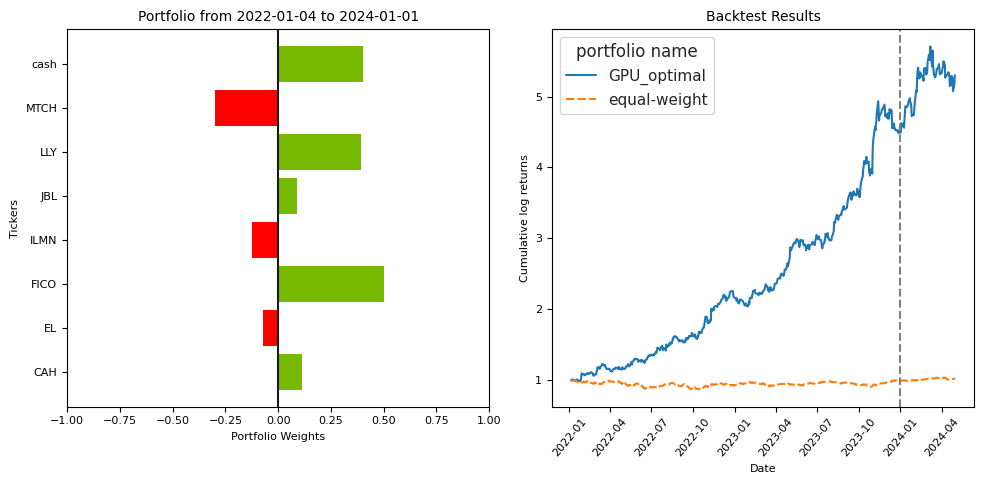

In [6]:
# Generate and display the backtest performance plot
utils.portfolio_plot_with_backtest(
    portfolio=gpu_portfolio,
    backtester=backtester,
    cut_off_date=cut_off_date,
    backtest_plot_title="Backtest Results",
)

In [ ]:
SPDX-FileCopyrightText: Copyright (c) 2025 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
SPDX-License-Identifier: MIT
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.